## Use case: Monitoring the spatial distribution of glaciers and their area changes in the context of water resource management at the local, regional, and global scale

## Quality assessment question: "How are glaciers spatially distributed across the globe around 2000 CE and how well can the dataset be used to relate climatic trends in glacierized areas to glacier area changes over time?"

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production and runoff, as well as for recreation and tourism. A proper assessment of glacierized areas, glacier characteristics, as well as their changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the 'Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000' dataset provides key information with respect to glacier extent and their characteristics. The RGI dataset namely is a collection of digital glacier and ice cap outlines at the global scale, nominally provided for the year 2000 CE. As it is the most complete dataset of glacier outlines with a global coverage, researchers often take this data to represent the current state of all glaciers and it has therefore been used accordingly for an impressive amount of (modelling) studies as a reference dataset. However, several known issues still persist in the dataset of which the user should take note before using the product. This notebook investigates how well the dataset can be used to (1) visualize the spatial distribution of glaciers worldwide using the gridded version of the dataset, (2) to estimate the total surface area covered by glaciers around 2000 CE, and (3) to calculate recent glacier area-weighted climatic trends from a combination of gridded RGI and ERA5-Land data in glacierized areas and relate them to glacier area changes. 

## Quality assessment statement

- The glaciers distribution (‘Randolph Glacier Inventory’ or RGI) dataset on the Climate Data Store (CDS) (here version v6.0 is used) is currently the most complete dataset of glacier outlines/extent data in terms of its spatial coverage and is generally considered the main reference dataset to determine the glaciers distribution across the globe around the year 2000 CE.
- The main results of this notebook show that the gridded version of the data is well-suited to visualize and inspect the global spatial distribution of glaciers and to quantify the glacierized surface area at the local (pixel), regional and global scale around the year 2000 CE. However, fractional areas are given in the gridded data, and thus the users need to calculate the absolute total glacierized area themselves (as these need to be converted from the pixel-by-pixel fractional glacierized area given by the gridded RGI data).
- The data are relatively well-suited to derive glacier area-weighted climatic (e.g. temperature) trends (in this notebook from ERA5-Land) in glacierized areas at various spatial scales, by using them as weights into a climatic anomaly/trend calculation. Calculated temperature trends hereby show a statistically significant and monotonically increasing trend over time at the global scale. However, the dataset an sich cannot be used to monitor climate change, nor the temporal evolution of glacier outlines (i.e. it is a snapshot in time around the year 2000 CE). Glacierized areas used as weights in the temperature anomaly/trend calculation are thus constant in time, which is in contrast with what could be expected from the calculated climatic trends in those regions.
- Other limitations also potentially affect the suitability of the glacier extent dataset for this purpose, such as the fact that the time of digitization of the glaciers not all correspond to the year 2000 CE, that the total surface glacierized area substantially differs among the vector and raster version of the dataset in regions RGI 14 and 15 (e.g. Li et al., 2021), or that some data are still subject to poor-quality outlines (e.g. for debris-covered glaciers, or when satellite imagery used for the digitization exhibited artefacts such as shadow or a seasonal snow cover).
- In other words, the dataset is not suitable to study temporal changes in glacier area despite the fact that in many regions significant climatic trends are associated with those areas. If necessary, the user therefore needs to search for and incorporate glacier area changes by using external data or other methods, as this info may impact the suitability of the data for similar glaciological, hydrological, and climatological applications such as for example for the purpose of water resource managemt at the local, regional or global scale.

## Methodology

#### Short description

The dataset of the glaciers distribution on the Climate Data Store (CDS) is an almost complete collection of digital glacier and ice cap outlines and their geometrical/hypsometrical characteristics from various data sources at the global scale (RGI Consortium, 2017). The dataset on the CDS is considered a snapshot of glacier outlines around the year 2000 CE, assembled mainly from satellite images, and is based on the Randolph Glacier Inventory (RGI), which is currently the most complete dataset of glacier outlines. Simply stated, the glaciers in the dataset were automatically classified using the distinctive spectral reflectance signatures of snow and ice. During post-processing, raw glacier outlines are quality checked and manually corrected if required (e.g. in the case of a supraglacial debris cover). The vector part of the dataset also devides the glaciers into separate RGI regions, i.e. there are 19 of those regions ("clusters" of glaciers) in RGIv6.0. For a more detailed description of the data acquisition and processing methods, we refer to the documentation on the CDS and the ECMWF Confluence Wiki. The resulting glacier extent data can be downloaded in vector topology or as raster-based data. 

#### Structure and (sub)sections

In this notebook, the applicability of RGIv6.0 data to serve as input data for the visualization of the spatial distribution of glaciers and the determination of the total glacierized area will be assessed. We will furthermore check whether the data are suitable to derive climatic trends in glacierized areas and whether we can link these trends to glacier area changes. This will be realized by analyzing the spatial distribution of glaciers at the global scale (here for the raster-type data), by discussing the potential limitations and error sources of the dataset, and by evaluating the implications for the usage of the data. The structure is as follows:

- **Data preparation and processing**: This section loads packages, defines requests for download from the CDS, downloads the actual data and inspects the data to reveal its structure. Also the plotting function that is used in this notebook is defined in this section.
- **Spatial distribution of glaciers**: This section assesses the spatial distribution of glaciers across the globe and quantifies the total glacierized area. The spatial distribution of glaciers is therefore analysed and plotted for each grid point within the dataset. The total glacierized area (assuming a spherical Earth) is calculated from the gridded dataset.
- **Glacier-area weighted air temperature trends in glacierized areas**: This section calculates glacier area-weighted temperature trends from ERA5-Land in glacierized areas. The analysis is done at the globe scale but can also be done for specific regions within certain delineated latitude/longitude boxes (here for example Svalbard). 
- **Other potential sources of error and uncertainty**: This section discusses additional limitations of the dataset, apart from the shortages discussed earlier, that can be of importance for this specific use case.
- **Suitability to derive glacier area changes for water resource management**: In this section, we finally discuss the suitability of the glacier extent data for the specific use case and thus check whether climatic trends can be linked to glacier area changes in the context of water resource management at the local, regional, and global scale.

## Analysis and results

### Data preparation and processing

First we load the packages:

In [44]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import linregress, kendalltau
from datetime import datetime
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

Then we define requests for download from the CDS and download the data. Since the data files to be downloaded and manipulated are quite large, this may take a couple of minutes.

In [45]:
# Glacier extent data
request_extent_gridded = (
    "insitu-glaciers-extent",
    {
        "variable":"glacier_area",
        "product_type":"gridded",
        "format":"zip",
        "version":"6_0",
    },
)

# Get glacier extent gridded data
df2 = download.download_and_transform(*request_extent_gridded)
print("Download glacier extent data ompleted.")

# ERA5-Land data
print("Downloading ERA5-Land data, this may take some minutes...")
request_era5_land = (
    "reanalysis-era5-land-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": ["2m_temperature"],
        "time": "00:00",
        "year": [f"{year:04d}" for year in range(1981,2023+1)],
        "month": [f"{month:02d}" for month in range(1, 12+1)],
        "grid":[1.0,1.0],
        "area": [np.max(df2["latitude"].values), np.min(df2["longitude"].values), np.min(df2["latitude"].values), np.max(df2["longitude"].values)],
        "format":"netcdf.zip",
    },
)

# Get ERA5-Land data
df_era5 = download.download_and_transform(*request_era5_land)
print("Download ERA5-Land completed.")

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


Download glacier extent data ompleted.


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

Download ERA5-Land completed.


We furthermore perform some data handling:

In [46]:
# Mask non-glacierized areas
masked_t2m = np.ma.masked_where(np.isnan(np.broadcast_to(df2["Glacier_area"], df_era5["t2m"].shape)),df_era5["t2m"])
df_era5["t2m"] = (('time', 'latitude', 'longitude'), masked_t2m)

# Resample data to annual values
df_era5 = df_era5.resample(time='YS').mean(dim='time')
# Calculate anomalies w.r.t. 1981-2010
df_era5['t2m_anomaly'] = df_era5['t2m'] - df_era5['t2m'].sel(time=slice('1981','2010')).mean(dim='time')
# Add time variable
df_era5["time"] = df_era5["time"].dt.year
df_era5["time"].attrs |= {"long_name":"time","units":"yr"}

Lastly, we can read and inspect the data. Let us print out the data to inspect its structure:

In [47]:
df2

<xarray.Dataset> Size: 249kB
Dimensions:       (latitude: 170, longitude: 360)
Coordinates:
  * longitude     (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude      (latitude) float64 1kB 84.5 83.5 82.5 ... -82.5 -83.5 -84.5
Data variables:
    Glacier_area  (latitude, longitude) float32 245kB dask.array<chunksize=(170, 360), meta=np.ndarray>
Attributes: (12/15)
    Source_Software:            Esri ArcGIS
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    title:                      Randolph Glacier Inventory v6 (RGI6) gridded ...
    project:                    Copernicus Climate Change Service (C3S) Essen...
    data_version:               version 6.0
    institution:                Department of Geography - University of Zuric...
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_resolution:  1.0
    references:                 Pfeffer et al. (2014) doi.org/10.3189/2014JoG...
    citation:                   RGI Consortium (2017): Randolph Glacier Inven...
    Conventions:                CF Version CF-1.0
    comment:                    Brief data description: Temporal resolution: ...

It is a gridded dataset at a 1 by 1 degree spatial resolution containing the fractional area of a grid cell covered by glaciers in the `Glacier_area` variable. Note that not all grid cells exhibit the same surface area, as grid cells get smaller towards the poles. This surface area is not included in the dataset.

### Spatial distribution of glaciers 

Let us check the spatial distribution of all glaciers in the dataset from the raster product. We therefore produce a world map where every grid cell represents the fractional glacierized area in that specific grid cell (in %):

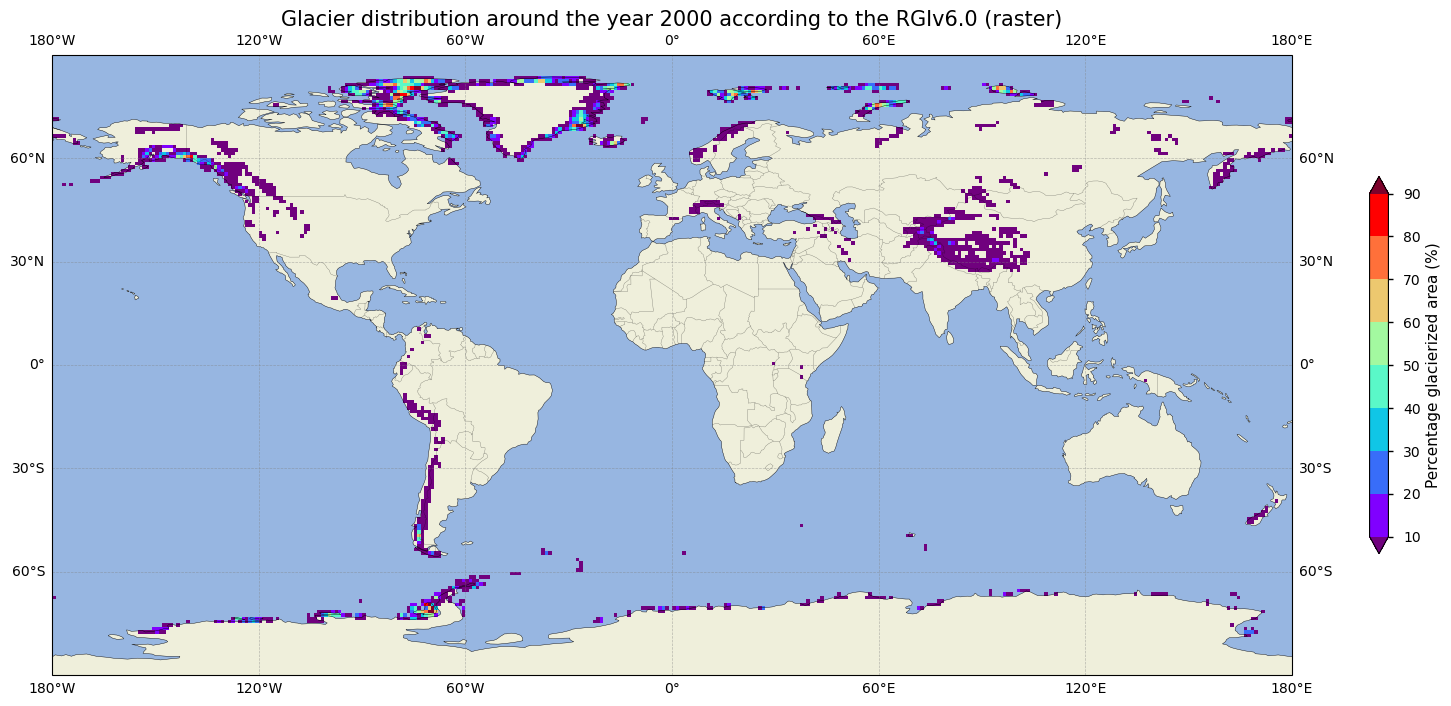

In [48]:
# Plot the gridded data
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(df2["longitude"].values, df2["latitude"].values, df2["Glacier_area"].values, transform=ccrs.PlateCarree(), cmap = mpl.cm.rainbow, norm = mpl.colors.BoundaryNorm(range(10, 100, 10), mpl.cm.rainbow.N))
im.cmap.set_over('#7E012B')
im.cmap.set_under('#70017E')
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Percentage glacierized area (%)')
plt.title('Glacier distribution around the year 2000 according to the RGIv6.0 (raster)',fontsize=15)
plt.show()

To calculate the total glacierized area from the raster product, we first need to find the surface area of a 1 by 1 degree pixel across the globe, which varies for each pixel (i.e. the surface area gets smaller towards the poles). After multiplying those respective surface areas by the fractional glacierized area of the corresponding pixel, and summing up all those values, we get an estimate of the total glacierized surface area. We assume the Earth to be a sphere so that:

$
\sum_{i=1}^n A_{glacier}\
$
[km²]
$
= \sum_{i=1}^n (\frac{1}{100}*A_{RGI,i}*A_{grid,i})
$
where
$
A_{grid,i} = R^2*(sin(lat_{i+1})-sin(lat_{i}))*(lon_{i+1}-lon_{i})
$
with
$
R
$
the radius of the Earth [km] and 
$
lat_i
$
and
$
lon_i
$
the center coordinates of each pixel $i$ [rad].

This results in the following surface area for the gridded product:

In [49]:
def surf_area_on_sphere(lat0, lat1, delta_lon, r):
    d2r = np.pi / 180.
    return d2r * delta_lon * r ** 2 * (
        np.sin(d2r * lat1) - np.sin(d2r * lat0))

# Constants for Earth (in kilometers)
earth_radius = 6378.0  # in km
a = earth_radius
b = earth_radius * 0.9933056  # Using Earth's oblateness for minor semi-axis

# Define latitude and longitude ranges
latitudes = np.arange(np.min(df2["latitude"].values), np.max(df2["latitude"].values+1), 1)  # Latitude range
longitudes = np.arange(np.min(df2["longitude"].values), np.max(df2["longitude"].values+1), 1)  # Longitude range

# Initialize variables to store total surface areas
surface_areas = np.zeros(np.shape(df2["Glacier_area"]))

# Calculate surface areas for each latitude and longitude
for i in range(len(latitudes) - 1):
    for j in range(len(longitudes) - 1):
        lat0 = latitudes[i]
        lat1 = latitudes[i + 1]
        delta_lon = longitudes[j + 1] - longitudes[j]

        # Calculate surface areas
        area_sphere = surf_area_on_sphere(lat0, lat1, delta_lon, earth_radius)
        
        # Store info
        surface_areas[i,j] = area_sphere

# Add surface area to xarray data
df2['Surface_area'] = (('latitude','longitude'),surface_areas)

# Calculate the total area covered by glaciers in the gridded dataset
total_area_gridded = np.nansum((df2["Surface_area"].values)*((df2["Glacier_area"].values)/100))
number_of_pixels = np.count_nonzero(~np.isnan(df2["Glacier_area"].values))

Now, we can finally plot the relevant data:

In [50]:
# Print relevant data
print( 
    f"A total number of {number_of_pixels} pixels (or {100*number_of_pixels/(len(latitudes)*len(longitudes)):.2f}%) hold glacier extent data in the raster dataset, "
    f"covering a total surface area of {total_area_gridded:.2f} km²."
)

A total number of 2105 pixels (or 3.44%) hold glacier extent data in the raster dataset, covering a total surface area of 733428.00 km².


Although the total surface area covered by glaciers slightly depends on the calculation of the absolute surface area per grid box (e.g. the assumption of a spherical Earth with radius R), this number deviates from the total surface area in the vector product of the dataset. Further investigation reveals that especially glacier surface extent data in RGI region 14 and 15 (South Asia West and South Asia East) are significantly underestimated in the gridded dataset when compared to the vector counterpart (i.e. up to >50% in RGI region 15 (Li et al., 2021)). Although this is out of scope for this specific notebook, the user should take extra care in these regions. 

### Glacier-area weighted air temperature trends in glacierized areas 

We can now calculate air temperature trends in glacierized areas. To be even more precise, we can weigh these temperature trends with the total surface area of glaciers in a certain pixel. Let us therefore first start by calculating the linear temperature trends from ERA5-Land data in pixels where glaciers occur according to the RGI:

In [52]:
print("Calculating trends... this may take a few moments.")
# Calculate trends pixel-by-pixel
# Extract t2m variable
t2m_data = df_era5['t2m']
# Reshape the data into a 2D array
t2m_2d = t2m_data.values.reshape(t2m_data.shape[0], -1)

## TEMPERATURE
# Prepare an array of time values for regression
time_values = np.arange(t2m_data.shape[0])
# Initialize an empty array to store trend values
trend_values = np.zeros(t2m_2d.shape[1])
p_values = np.zeros(t2m_2d.shape[1])
# Loop through each grid point and calculate the trend using linear regression
for i in range(t2m_2d.shape[1]):
    y = t2m_2d[:, i]
    X = sm.add_constant(time_values)
    model = sm.OLS(y, X)
    results = model.fit()
    trend_values[i] = results.params[1]  # slope coefficient represents the trend
    p_values[i] = results.pvalues[1]  # p-value of the slope
# Reshape the trend values back into the original grid shape
trend_grid = trend_values.reshape(t2m_data.shape[1:])
p_value_grid = p_values.reshape(t2m_data.shape[1:])
# Add to dataframe
df_era5['t2m_trend']=(('latitude','longitude'),trend_grid)
df_era5['t2m_p_value'] = (('latitude','longitude'),p_value_grid)
print("Trend calculation completed.")

Calculating trends... this may take a few moments.
Trend calculation completed.


These data can also be plotted on a world map:

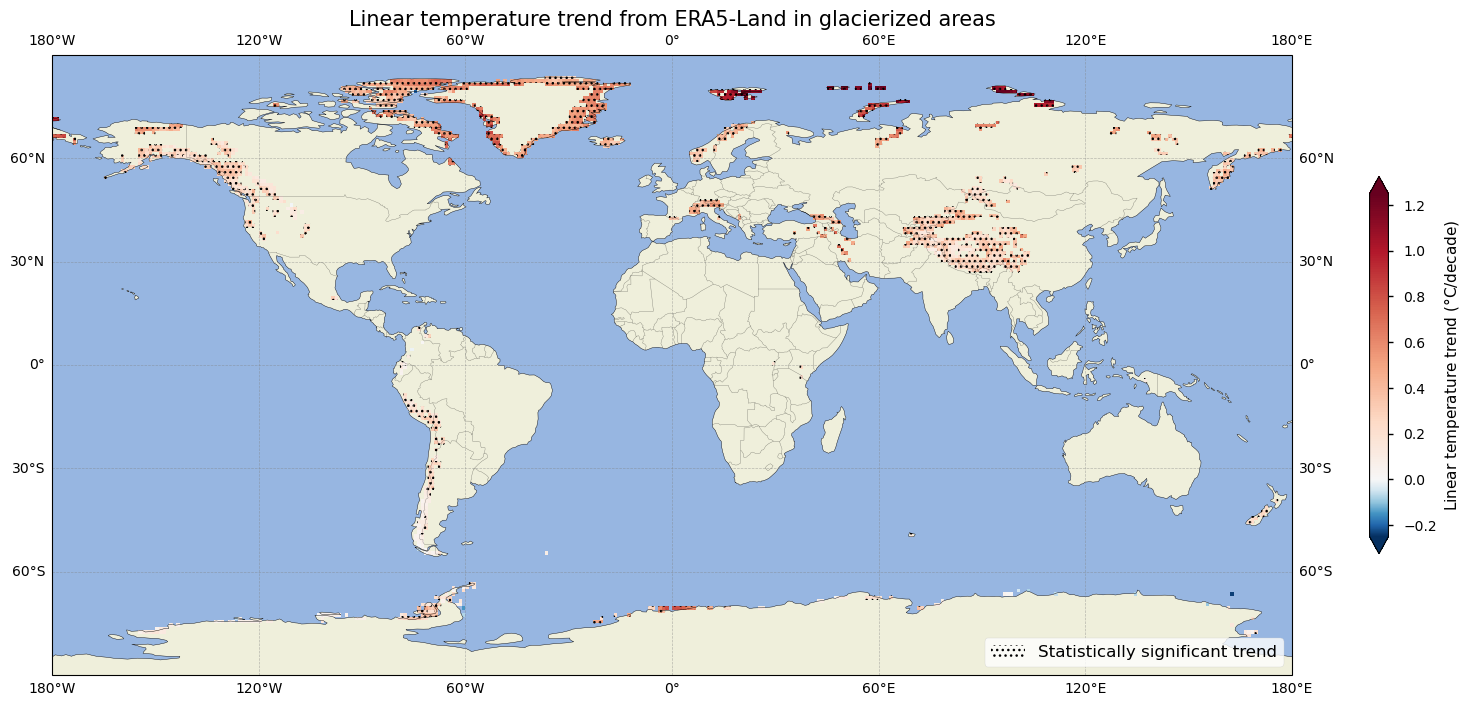

In [105]:
# Plot the gridded data
significance_level = 0.05
significant = df_era5['t2m_p_value'].values < significance_level
lon_grid, lat_grid = np.meshgrid(df2["longitude"].values, df2["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
masked_t2m = np.ma.masked_where(np.isnan(df2["Glacier_area"]),df_era5["t2m_trend"])
im=ax.pcolormesh(df_era5["longitude"].values, df_era5["latitude"].values, (masked_t2m*10), transform=ccrs.PlateCarree(), cmap = mpl.cm.RdBu_r, norm=mpl.colors.TwoSlopeNorm(vmin=-0.25,vcenter=0,vmax=1.25))
cb = fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Linear temperature trend ($\degree$C/decade)')
cb.ax.set_yscale('linear')
#ax.scatter(lon_grid[significant], lat_grid[significant], color='k', s=0.25, transform=ccrs.PlateCarree(), label='Statistically significant trend')
ax.pcolor(lon_grid, lat_grid, np.ma.masked_less(significant, 1), transform=ccrs.PlateCarree(), hatch='...', alpha=0, linewidths=0.1, label='Statistically significant trend')
ax.legend(loc='lower right', fontsize=12)
plt.title('Linear temperature trend from ERA5-Land in glacierized areas',fontsize=15)
plt.show()

If areas on the map are stippled, it indicates that the temperature trends in those regions are statistically significant. In other words, the observed trends in temperature are unlikely to have occurred by random chance alone, based on the chosen significance level (0.05). Let us now inspect the zonval averages of these temperature trends to get a better idea of the geographical distribution of warming trends:

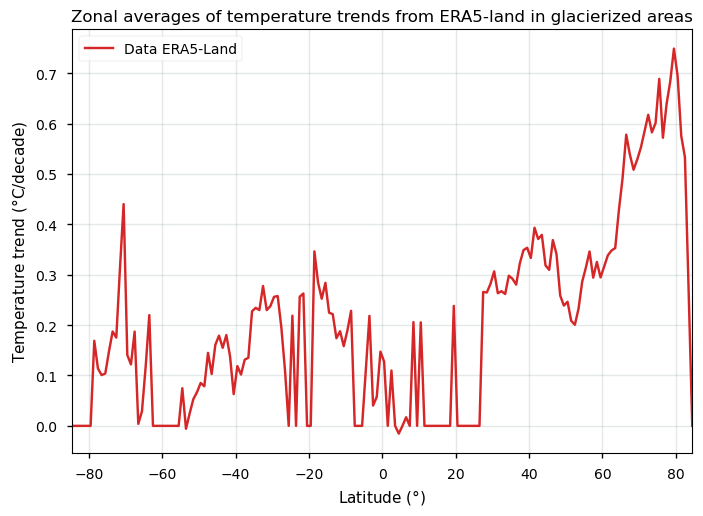

In [20]:
zonal_trends = (df_era5['t2m_trend']*10).mean(dim='longitude').fillna(0)
# Plot data
fig,ax=plt.subplots()
plt.plot(zonal_trends['latitude'].values,zonal_trends,color='C3',label='Data ERA5-Land')
plt.xlabel('Latitude ($\degree$)')
plt.ylabel('Temperature trend ($\degree$C/decade)')
plt.title('Zonal averages of temperature trends from ERA5-land in glacierized areas')
plt.legend()
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(zonal_trends['latitude'].values),np.max(zonal_trends['latitude'].values))
plt.show()

From the above map and plot, it is obvious that negative temperature trends dominate throughout the globe. The most negative trends (in $\degree$C per decade) seem to occur at the higher latitudes (e.g. above 70$\degree$ N). Let us now express the above-displayed information in a global glacierized area-weighted linear temperature trend. We therefore create weights in terms of absolute glacierized surface areas and multiply it with the annual temperature anomaly in that corresponding pixel during a certain year to get an annual glacier area-weighted temperature anomaly $\Delta {T}$:

$
\Delta {T}_y = \textstyle\frac{1}{\sum_{i=1}^n A_{glacier,i}} {\sum_{i=1}^n (A_{glacier,i}*\Delta T_{i,y}})
$
where
$
A_{glacier,i} 
$
and 
$
\Delta T_{i,y}
$
are the glacierized area [km²] (constant in time) and annual temperature anomaly [$\degree$C] (different in each year) for pixel $i$ and year $y$ respectively, and $n$ the total number of pixels with glaciers.

By performing this calculation for each year in the time series and calculating the corresponding linear trend over time, it results in the following:

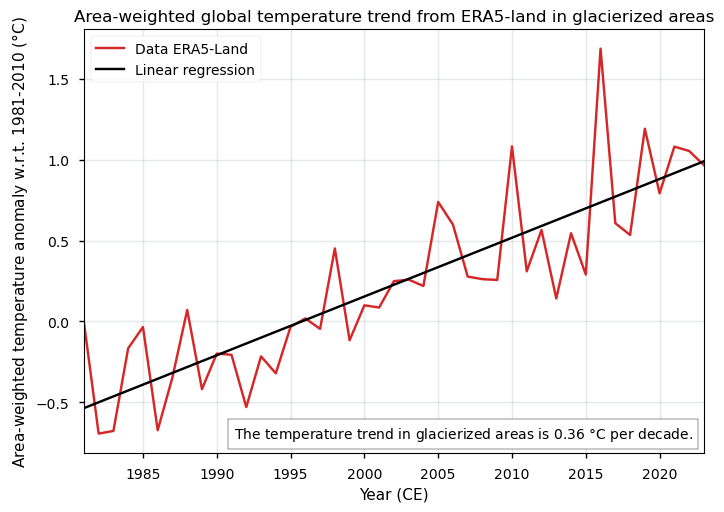

In [36]:
yrs_era5 = np.linspace(np.min(df_era5["time"].values),np.max(df_era5["time"].values),num=np.max(df_era5["time"].values)-np.min(df_era5["time"].values)+1)
# Trend in glacierized areas weighted by glacierized area
weight_glaciers = ((df2["Surface_area"].values)*((df2["Glacier_area"].values)/100)) / np.nansum((df2["Surface_area"].values)*((df2["Glacier_area"].values)/100))
ts_glacier = ((df_era5['t2m_anomaly']) * weight_glaciers).sum(dim=['longitude','latitude']).to_dataframe(name='Glacier')
# Plot data
fig,ax=plt.subplots()
slope, intercept, r_value, p_value_trend, std_err = linregress(yrs_era5, ts_glacier.Glacier)
tau, p_value_mk = kendalltau(yrs_era5, ts_glacier.Glacier)
linear_regression_line = slope * yrs_era5 + intercept
plt.plot(yrs_era5,ts_glacier.Glacier,color='C3',label='Data ERA5-Land')
plt.plot(yrs_era5, linear_regression_line, color='black', label='Linear regression')  
plt.xlabel('Year (CE)')
plt.ylabel('Area-weighted temperature anomaly w.r.t. 1981-2010 ($\degree$C)')
plt.title('Area-weighted global temperature trend from ERA5-land in glacierized areas')
plt.legend()
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(yrs_era5),np.max(yrs_era5))
_ = ax.text(
    0.242,
    0.035,
    f"The temperature trend in glacierized areas is {(slope)*10:.2f} $\degree$C per decade.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
plt.show()

We can investigate the statistical significance and monotonicity of the calculated temperature trend based on a chosen significance level (0.05):

In [38]:
# Check significance
if p_value_trend < 0.05:
    print("The global temperature trend in glacierized areas is statistically significant.")
else:
    print("The global temperature trend in glacierized areas is not statistically significant.")
# Check monotonicity
if p_value_mk < 0.05:
    if tau > 0:
        print("There is a statistically significant monotonically increasing trend.")
    elif tau < 0:
        print("There is a statistically significant monotonically decreasing trend.")
else:
    print("There is no statistically significant monotonic trend.")

The global temperature trend in glacierized areas is statistically significant.
There is a statistically significant monotonically increasing trend.


Some visual inspection and the tests for statistical significance already yield some interesting results! We can also plot this in the style of the popular climate [warming stripes](https://showyourstripes.info):

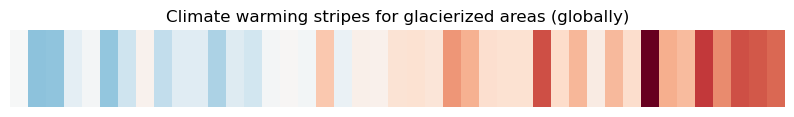

In [39]:
# Configure the figure
figure, axis = plt.subplots(1, 1, figsize=(10, 1))
axis.set_xlim(0, ts_glacier.size)
axis.set_axis_off()

# Define a red (positive trends) to blue (negative trends) colorscale
colormap = plt.get_cmap('RdBu_r')

# Saturate colors 
normalizer = mpl.colors.Normalize(vmin=-np.max(np.abs(ts_glacier.Glacier)), vmax=np.max(np.abs(ts_glacier.Glacier)))

# Create a colored rectangle for each year
for i, value in enumerate(ts_glacier.Glacier):
    axis.add_patch(mpl.patches.Rectangle(
        xy=(i, 0), width=1, height=1, facecolor=colormap(normalizer(value))
    ))

# Show figure
plt.title('Climate warming stripes for glacierized areas (globally)')
plt.show()

Warming trends thus seem to clearly dominate in glacierized areas during the last several decades. Let us now zoom in on a certain region. We can, for example, create a latitide/longitude box around the area of Svalbard to inspect warming trends over the high latitudes. Likewise, we calculate the glacier area-weighted temperature trend in this region:

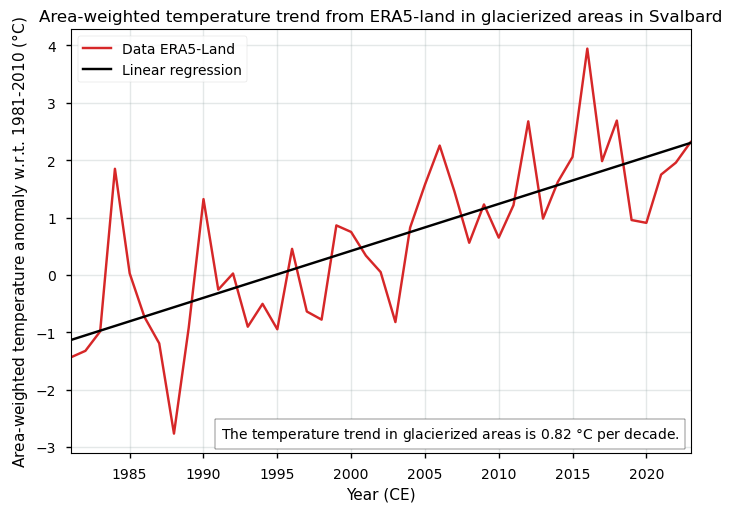

In [40]:
# Define bounding box for Svalbard
lat_max = 81
lat_min = 74
lon_min = 10
lon_max = 35

# Filter the data within the bounding box
df2_box = df2.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
df_era5_box = df_era5.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

yrs_era5 = np.linspace(np.min(df_era5_box["time"].values),np.max(df_era5_box["time"].values),num=np.max(df_era5_box["time"].values)-np.min(df_era5_box["time"].values)+1)
# Trend in glacierized areas weighted by glacierized area
weight_glaciers = ((df2_box["Surface_area"].values)*((df2_box["Glacier_area"].values)/100)) / np.nansum((df2_box["Surface_area"].values)*((df2_box["Glacier_area"].values)/100))
ts_glacier = ((df_era5_box['t2m_anomaly']) * weight_glaciers).sum(dim=['longitude','latitude']).to_dataframe(name='Glacier')
# Plot data
fig,ax=plt.subplots()
slope, intercept = np.polyfit(yrs_era5, ts_glacier.Glacier, 1)
linear_regression_line = slope * yrs_era5 + intercept
plt.plot(yrs_era5,ts_glacier.Glacier,color='C3',label='Data ERA5-Land')
plt.plot(yrs_era5, linear_regression_line, color='black', label='Linear regression')  
plt.xlabel('Year (CE)')
plt.ylabel('Area-weighted temperature anomaly w.r.t. 1981-2010 ($\degree$C)')
plt.title('Area-weighted temperature trend from ERA5-land in glacierized areas in Svalbard')
plt.legend()
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(yrs_era5),np.max(yrs_era5))
_ = ax.text(
    0.242,
    0.035,
    f"The temperature trend in glacierized areas is {(slope)*10:.2f} $\degree$C per decade.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
plt.show()

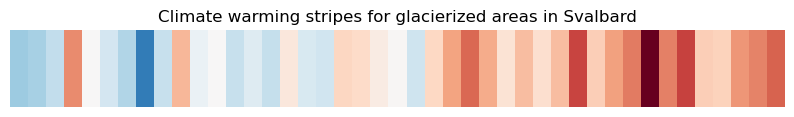

In [41]:
# Configure the figure
figure, axis = plt.subplots(1, 1, figsize=(10, 1))
axis.set_xlim(0, ts_glacier.size)
axis.set_axis_off()

# Define a red (positive trends) to blue (negative trends) colorscale
colormap = plt.get_cmap('RdBu_r')

# Saturate colors 
normalizer = mpl.colors.Normalize(vmin=-np.max(np.abs(ts_glacier.Glacier)), vmax=np.max(np.abs(ts_glacier.Glacier)))

# Create a colored rectangle for each year
for i, value in enumerate(ts_glacier.Glacier):
    axis.add_patch(mpl.patches.Rectangle(
        xy=(i, 0), width=1, height=1, facecolor=colormap(normalizer(value))
    ))

# Show figure
plt.title('Climate warming stripes for glacierized areas in Svalbard')
plt.show()

As noted before, the warming trends are even more clear in the higher latitudes. This is consistent with a phenomenom called [polar amplification](https://en.wikipedia.org/wiki/Polar_amplification) and is related to several positive feedback mechanisms, such as the ice-albedo feedback. Since the majority of the glacierized area tends to be located at these higher latitudes (see our world map earlier), these areas will therefore move the global trends towards warmer temperatures!

#### Other potential sources of error and uncertainty

Other potential sources of uncertainty for the glacier extent data in the gridded version of RGIv6.0 include a low resolution and quality of the source data, a poor skill of the digitizer, the presence of shadow or clouds on the satellite images, poor availability of multi-temporal satellite images, the presence of supraglacial and proglacial lakes, and the presence of seasonal snow fields. The largest source of misdelineation of glaciers is, however, the presence of supraglacial debris. For glaciers with extensive debris cover or for rock glaciers, the accuracy can therefore be significantly impacted (Paul et al., 2013). This is related to the fact that the spectral signature of debris is very similar to that of the surrounding moraines and bedrock when deriving glacier outlines from satellite imagery. In regions with large debris cover (e.g. High Mountain Asia or the Caucasus), the user should be aware that the glacier area can be significantly underestimated due to the presence of debris. Moreover, another well-known problem of the dataset is the fact that not all digitized glacier information exactly corresponds to data in the year 2000 CE, as is nevertheless stated in the title of the dataset. Nonetheless, although most information dates back to the timeframe between 2000 and 2010 CE, certain regions in the world exhibit information that dates further back into the 20th century and can hence be interpeted as outdated data.  Due to the observed worldwide shrinkage of the glacierized area (e.g. Zemp et al., 2019), a very likely underestimation of the glacierized area estimate for 2000 CE occurs for glaciers digitized after 2000 CE, while else a very likely area overestimation occurs. 

Another issue of the dataset is the unclear interpretation of what a glacier is. As the glacier outlines were created by a globally diverse community, the interpretation of what a glacier or ice cap is (do ice walls need to be included, how do tributaries need to be treated, which type of glaciers should be added, how to divide glacier complexes into separate entities, from which threshold size onwards can we speak of a glacier) deviates among data sources. In this context, debris-covered/rock glaciers (where it is difficult to distinguish debris-covered ice from bedrock) and also the peripheral glaciers of Antarctica and Greenland (where it is difficult to distinguish (outlet) glaciers from the main ice sheet bodies) remain a struggle (Hock et al., 2022). Specific attention of the user is therefore required in these areas. Ice bodies smaller than a regionally variable threshold size were furthermore not added (as being the supposed minimum size for ice flow and also to exclude (seasonal) snow fields). This implies that in some regions, glaciers smaller than this threshold were not included in the dataset, which leads to an underestimation of the glacier surface (RGI Consortium, 2017). Adding to this, the total glacierized area in the gridded product differs from corresponding numbers of the vector version of the data, which is especially related to a significant underestimation of the glacier surface area in RGI regions 14 and 15 in the raster product in RGIv6.0. 

Quantitative estimates of the errors and the related uncertainty are not given in the gridded data. However, an error model can be found in Pfeffer et al. (2014) for glacier outline polygons. Here, it is stated that the relative error of the glacier area is larger for small glaciers than for large glaciers because small glaciers have a larger outline to area ratio. Based on the above, the uncertainty of an individual glacier outline, supposingly being representative for 2000 CE, therefore depends upon both the quality of the source material and the characteristics of the specific glacier. It is, however, unclear how this translates into the gridded version of the data.

#### Suitability to relate climatic trends to glacier area changes for water resource management purposes

With all the information above, we can try to formulate an answer to the specific use case and user question. One factor to take into account when using the data is that the glacier extent data from the RGI an sich cannot be used to monitor climate change. The glacier extent data are designed to represent the state of the world's glaciers around the year 2000 CE and can thus be considered a snapshot in time. Assessing the temporal evolution of glaciers, their outlines and their characteristics is hence not possible with this dataset. 

This also has implications for our glacier area-weighted temperature trends calculation. Indeed, the glacierized areas from which the weights in the trend are created are constant in time. Although the RGIv6.0 data do not include information on temporal changes of the glacier extent, Zemp et al. (2015),  Li et al. (2019) and Zemp et al. (2019) concluded that glacier retreat has been dominant during the last several decades, with the 21st century marking the historical minimum glacier extent in almost all regions across the globe since at least the 1500s. Results from Li et al. (2019) show that during the period 1980–2015, the rate of global glacier area change was -0.18% per year. Zemp et al. (2019) estimates this number to be -0.34% per year between 1961-2016. From a global record of 471 glacier length change data, Leclerq et al. (2014) furthermore found a median retreat rate over the 1961-2000 period of 7.4 meter per year. These findings indicate rapidly changing glacier conditions (and outlines), with observed glacier shrinkage and retreat in every RGI region during the last several decades (Li et al., 2019). The observed changes of the glacierized area from the literature, as well as the temperature trends calculated above, imply a very likely overestimation of the volume estimate for glaciers digitized before 2000 CE, and an underestimation else. The actual retreat and shrinkage (i.e. volume response time) of individual glaciers, however, is dictated by both geometric/topographic factors, such as the slope and the initial glacier size, and on local climatic conditions (Zemp et al., 2015). 

Eventually, the gridded glacierized area data from the RGI are not suitable to link climatic trends to glacier area changes as the data represent a signle snapshot around the year 2000 CE, and thus the user has to take into account the glacier area change throughout time using external data or other methods (e.g. from Zemp et al. (2019) for each RGI region) between 2000 CE and the desired point in time of the user. This info impacts the suitability of the data for  glaciological, hydrological, and climatological applications such as for example for the purpose of water resource managemt at the local, regional or global scale. The meltwater runoff coming from glaciers namely is highly area-dependent, and glacier area changes over time will result in a "peak water discharge" (e.g. Huss and Hock, 2018). This is because when large glaciers are in imbalance with a climate that is too warm (or dry), they lose larger amounts of ice and produce increasing runoff volumes when the temperature rises. However, as the glacier further shrinks, the amount of ice that is able to produce runoff decreases as well, resulting in gradually less meltwater runoff. In between those two states, a maximum is reached where the glacier produces the highest runoff volumes (i.e. the peak water discharge), which is thus highly dependent upon glacier area changes. Not taking into account these glacier area changes would thus (significantly) impact glacier runoff volumes in a future warming climate and is hence a factor to be considered by users of this dataset.

## If you want to know more

### Key resources

- "Glaciers distribution data from the Randolph Glacier Inventory for year 2000" on the CDS
- "ERA5-Land monthly averaged data from 1950 to present" on the CDS

### References

- Huss, M., and Hock, R. (2018). Global-scale hydrological response to future glacier mass loss, Nature Climate Change, 8, 135–140 (2018), doi: 10.1038/s41558-017-0049-x.

- Hock, R., Maussion, F., Marzeion, B., and Nowicki, S. (2022). What is the global glacier ice volume outside the ice sheets? Journal of Glaciology, 69(273), 204–10. doi: 10.1017/jog.2023.1.

- Leclercq, P. W., Oerlemans, J., Basagic, H. J., Bushueva, I., Cook, A. J., and Le Bris, R. (2014). A data set of worldwide glacier length fluctuations, Cryosphere, 2014(8), 659–672. doi: 10.5194/tc-8-659-2014.

- Li, Y. J., Ding, Y. J., Shangguan, D. H., and Wang, R. J. (2019). Regional differences in global glacier retreat from 1980 to 2015, Advances in Climate Change Research, 10(4), 203–213. doi: 10.1016/j.accre.2020.03.003.

- Li, Y. J., Li, F., Shangguan, D. H., Ding, Y. J. (2021). A New Global Gridded Glacier Dataset Based on the Randolph Glacier Inventory Version 6.0. Journal of Glaciology, 67 (2021), 773–76. doi: 10.1017/jog.2021.28.

- Paul, F., Barrand, N. E., Baumann, S., Berthier, E., Bolch, T., Casey, K., Frey, H., Joshi, S. P., Konovalov, V., Le Bris, R., Mölg, N., Nosenko, G., Nuth, C., Pope, A., Racoviteanu, A., Rastner, P., Raup, B., Scharrer, K., Steffen, S., and Winsvold, S. (2013). On the Accuracy of Glacier Outlines Derived from Remote-Sensing Data. Annals of Glaciology, 54(63), 171–82. doi: 10.3189/2013AoG63A296.

- Pfeffer, W. T., Arendt, A. A., Bliss, A., Bolch, T., Cogley, J. G., Gardner, A. S., Hagen, J. O., Hock, R., Kaser, G., Kienholz, C., Miles, E. S., Moholdt, G., Mölg, N., Paul, F., Radić, V., Rastner, P., Raup, B. H., Rich, J., Sharp, M. J., and Glasser, N. (2014). The Randolph Glacier Inventory: A globally complete inventory of glaciers, Journal of Glaciology, 60(221), 537-552. doi: 10.3189/2014JoG13J176.

- RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- Zemp, M., Frey, H., Gärtnew-Roer, I., Nussbaumer, S. U., Helzle, M., Paul, F., Haeberli, W., Denzinger, F., Ahlstrøm, A. P., Anderson, B., Bajracharya, S., Baroni, C., Braun, L. N., Cáceres, B. E., Casassa, G., Cobos, G., Dávila, L. R., Delgado Granados, H., Demuth, M. N., Espizua, L., Fischer, A., Fujita, K., Gadek, B., Ghazanfar, A., Hagen, J. O., Holmlund, P., Karimi, N., Li, Z., Pelto, M., Pitte, P., Popovnin, V. V., Portocarrero, C. A., Prinz, R., Sangewar, C. V., Severskiy, I., Sigurdsson, O., Soruco, A., Usubaliev, R., and Vincent, C. (2015). Historically unprecedented global glacier decline in the early 21st century, Journal of Glaciology, 61, 745-762. doi: 10.3189/2015JoG15J017.

- Zemp, M., Huss, M., Thibert, E., Eckert, N., McNabb, R., Huber, J., Barandun, M., Machguth, H., Nussbaumer, S. U., Gärtner-Roer, I., Thomson, L., Paul, F., Maussion, F., Kutuzov, S., and Cogley, J. G. (2019). Global glacier mass changes and their contributions to sea-level rise from 1961 to 2016. Nature, 568, 382–386. doi: 10.1038/s41586-019-1071-0.